RF best params: {'model__max_depth': None, 'model__n_estimators': 100}
GB best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}

RandomForest
Accuracy: 0.9111  Macro-F1: 0.9107


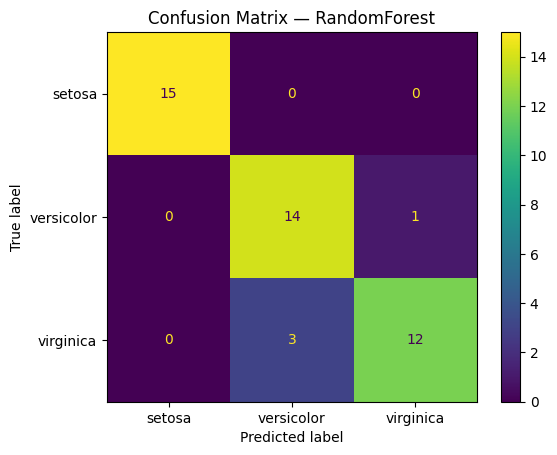


GradientBoosting
Accuracy: 0.8889  Macro-F1: 0.8878


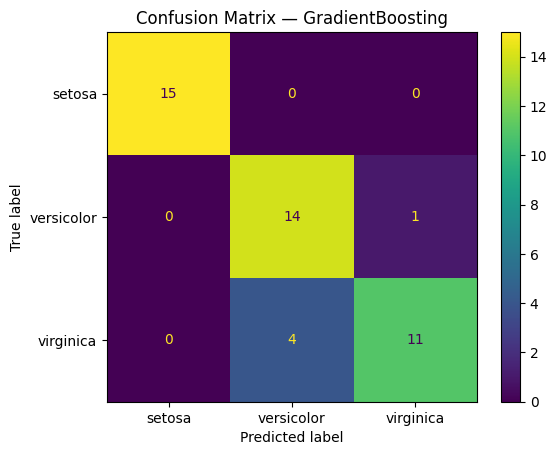


Results:
               model  accuracy  f1_macro
0      RandomForest  0.911111  0.910714
1  GradientBoosting  0.888889  0.887767
Saved best model to: ml_projects/models/best_model.joblib | Best: RandomForest


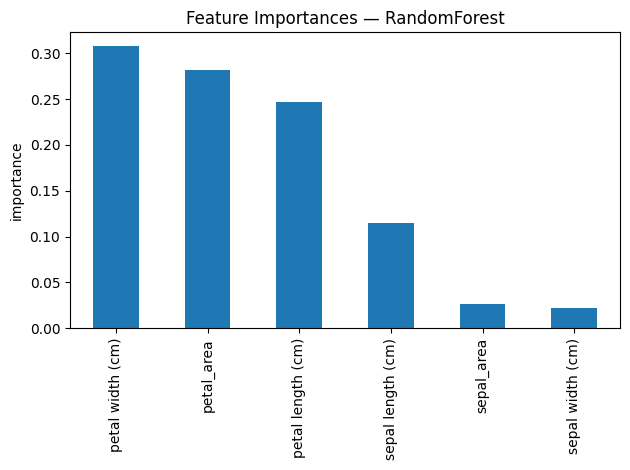

In [1]:
# === Part 4: Model comparison + export best model (all-in-one cell) ===
import os, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

# Ensure cleaned dataset exists (create if missing)
CLEAN_PATH = "ml_projects/data/iris_cleaned_engineered.csv"
os.makedirs("ml_projects/data", exist_ok=True)

if not os.path.exists(CLEAN_PATH):
    iris = load_iris(as_frame=True)
    df0 = iris.frame.copy()
    df0.rename(columns={'target': 'species_index'}, inplace=True)
    df0['species'] = df0['species_index'].map(dict(enumerate(iris.target_names)))
    # simple features + scaling to mimic Part 2
    df0['sepal_area'] = df0['sepal length (cm)'] * df0['sepal width (cm)']
    df0['petal_area'] = df0['petal length (cm)'] * df0['petal width (cm)']
    num_cols = [c for c in df0.columns if df0[c].dtype != 'object' and c != 'species_index']
    scaler = StandardScaler()
    df0[num_cols] = scaler.fit_transform(df0[num_cols])
    df0.to_csv(CLEAN_PATH, index=False)
    print("Created:", CLEAN_PATH)

# Load cleaned data
df = pd.read_csv(CLEAN_PATH)
X = df.drop(columns=['species','species_index'])
y = df['species']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Pipelines + grids
rf_pipe = Pipeline([('model', RandomForestClassifier(random_state=42))])
gb_pipe = Pipeline([('model', GradientBoostingClassifier(random_state=42))])

rf_grid = {'model__n_estimators': [100, 300], 'model__max_depth': [None, 3, 5]}
gb_grid = {'model__n_estimators': [100, 200], 'model__learning_rate': [0.1, 0.05], 'model__max_depth': [2, 3]}

rf_cv = GridSearchCV(rf_pipe, rf_grid, cv=5, scoring='f1_macro', n_jobs=-1)
gb_cv = GridSearchCV(gb_pipe, gb_grid, cv=5, scoring='f1_macro', n_jobs=-1)

rf_cv.fit(X_train, y_train)
gb_cv.fit(X_train, y_train)

print("RF best params:", rf_cv.best_params_)
print("GB best params:", gb_cv.best_params_)

# Evaluate & compare
models = {'RandomForest': rf_cv.best_estimator_, 'GradientBoosting': gb_cv.best_estimator_}
rows = []
for name, mdl in models.items():
    y_pred = mdl.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    rows.append((name, acc, f1m))
    print(f"\n{name}\nAccuracy: {acc:.4f}  Macro-F1: {f1m:.4f}")
    cm = confusion_matrix(y_test, y_pred, labels=mdl.classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl.classes_).plot()
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

results = pd.DataFrame(rows, columns=['model','accuracy','f1_macro'])
print("\nResults:\n", results)

# Pick best by Macro-F1 and save
best_name = results.sort_values('f1_macro', ascending=False).iloc[0]['model']
best_model = models[best_name]
os.makedirs("ml_projects/models", exist_ok=True)
MODEL_PATH = "ml_projects/models/best_model.joblib"
joblib.dump(best_model, MODEL_PATH)
print("Saved best model to:", MODEL_PATH, "| Best:", best_name)

# Feature importances if available
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    importances = best_model.named_steps['model'].feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    ax = feat_imp.plot(kind='bar')
    ax.set_title(f'Feature Importances — {best_name}')
    ax.set_ylabel('importance')
    plt.tight_layout()
    plt.show()
else:
    print("Best model has no native feature_importances_.")
